Task 3: Customer Churn Prediction

In [1]:
# Core
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Metrics & plots
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Save / load model
import joblib


In [2]:
# Update the filename if needed
df = pd.read_csv("churn_modelling.csv")

print("Shape:", df.shape)
display(df.head())
df.info()


Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [3]:
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [4]:
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"], errors="ignore")
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
target_col = "Exited"
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

print("Features:", X.columns.tolist())
print("Target distribution:\n", y.value_counts())


Features: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Target distribution:
 Exited
0    7963
1    2037
Name: count, dtype: int64


In [6]:
cat_cols = ["Geography", "Gender"]
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols, num_cols


(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

In [7]:
numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)
print("Model trained ✅")


Model trained ✅


Accuracy: 0.858

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



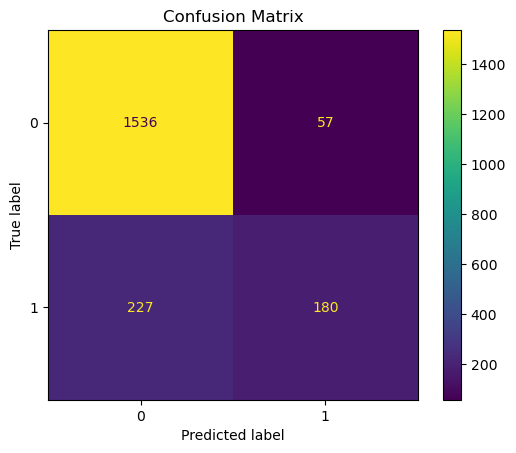

In [9]:
y_pred = model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()


In [10]:
# Get feature names after preprocessing
ohe = model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(cat_cols)  # e.g., Geography_Germany, Gender_Male, ...

all_feature_names = np.r_[num_cols, ohe_feature_names]   # numeric + one-hot cat features

importances = model.named_steps["clf"].feature_importances_
fi = pd.DataFrame({"feature": all_feature_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False).reset_index(drop=True)

fi.head(20)


,feature,importance
0,Age,0.239542
1,EstimatedSalary,0.147393
2,CreditScore,0.142905
3,Balance,0.140811
4,NumOfProducts,0.126152
5,Tenure,0.084203
6,IsActiveMember,0.038371
7,Geography_Germany,0.022557
8,HasCrCard,0.019429
9,Geography_France,0.010752


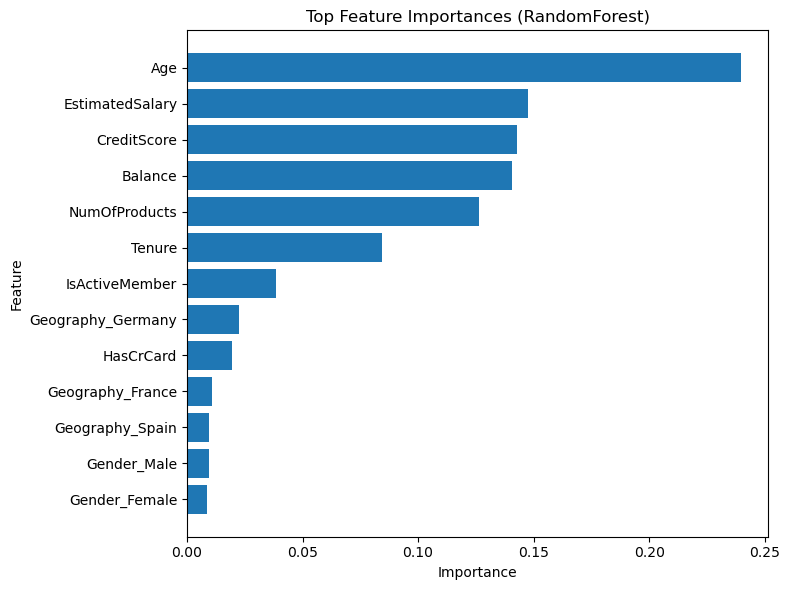

In [11]:
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(fi["feature"][:top_n][::-1], fi["importance"][:top_n][::-1])
plt.title("Top Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [12]:
# Example: change these values to test different scenarios
new_customer = {
    "CreditScore": 650,
    "Geography": "Germany",     # France/Germany/Spain in common dataset
    "Gender": "Male",           # Male/Female
    "Age": 42,
    "Tenure": 5,
    "Balance": 85000.0,
    "NumOfProducts": 2,
    "HasCrCard": 1,
    "IsActiveMember": 1,
    "EstimatedSalary": 120000.0
}

# Put into DataFrame with exact X columns order
new_df = pd.DataFrame([new_customer])[X.columns]

pred = model.predict(new_df)[0]
proba = model.predict_proba(new_df)[0]  # [prob_stay, prob_churn] for RF

print("Prediction (1 = Churn, 0 = Stay):", int(pred))
print("Probabilities -> Stay:", round(proba[0], 3), "| Churn:", round(proba[1], 3))


Prediction (1 = Churn, 0 = Stay): 0
Probabilities -> Stay: 0.97 | Churn: 0.03


In [13]:
# Save
joblib.dump(model, "task3_churn_model.joblib")
print("Saved: task3_churn_model.joblib")

# Load (example)
loaded_model = joblib.load("task3_churn_model.joblib")
print("Loaded model ✔")


Saved: task3_churn_model.joblib
Loaded model ✔
